# Import Libraries

In [4]:
pip install category-encoders

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.0/82.0 kB 6.7 MB/s eta 0:00:00


In [37]:
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.pipeline import Pipeline
from category_encoders.target_encoder import TargetEncoder
from xgboost import XGBRegressor
from skopt import BayesSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import accuracy_score,mean_absolute_error, mean_squared_error, r2_score
import seaborn as sns
import matplotlib.pyplot as plt

# Step 1 - Explore and prep data

In [10]:
df = pd.read_csv("/content/car_prices.csv")

In [11]:
df.describe(include=['object'])

,make,model,trim,body,transmission,vin,state,color,interior,seller,saledate
count,359291,359227,358962,356418,325501,365518,365518,364994,364994,365518,365516
unique,95,943,1871,46,2,360107,37,20,17,11531,2414
top,Ford,Altima,Base,Sedan,automatic,5uxfe43579l274932,ca,black,black,ford motor credit company llc,Tue Feb 10 2015 01:30:00 GMT-0800 (PST)
freq,61416,13090,36868,157890,313851,4,51973,72277,155587,12737,5334


In [12]:
# Select categorical columns
categorical_columns = ['make','model','trim','body','transmission','vin','state','color','interior','seller','saledate']

In [13]:
df.describe()

,year,condition,odometer,mmr,sellingprice
count,365518.000000,353725.000000,365433.000000,365516.000000,365516.000000
mean,2009.816939,30.378130,70159.536665,13364.257994,13205.300635
std,4.043974,13.637981,54538.500245,9416.170951,9503.107709
min,1982.000000,1.000000,1.000000,25.000000,1.000000
25%,2007.000000,23.000000,28586.000000,6600.000000,6400.000000
50%,2011.000000,34.000000,54298.000000,12050.000000,11900.000000
75%,2013.000000,41.000000,102453.000000,17900.000000,17800.000000
max,2015.000000,49.000000,999999.000000,176000.000000,230000.000000


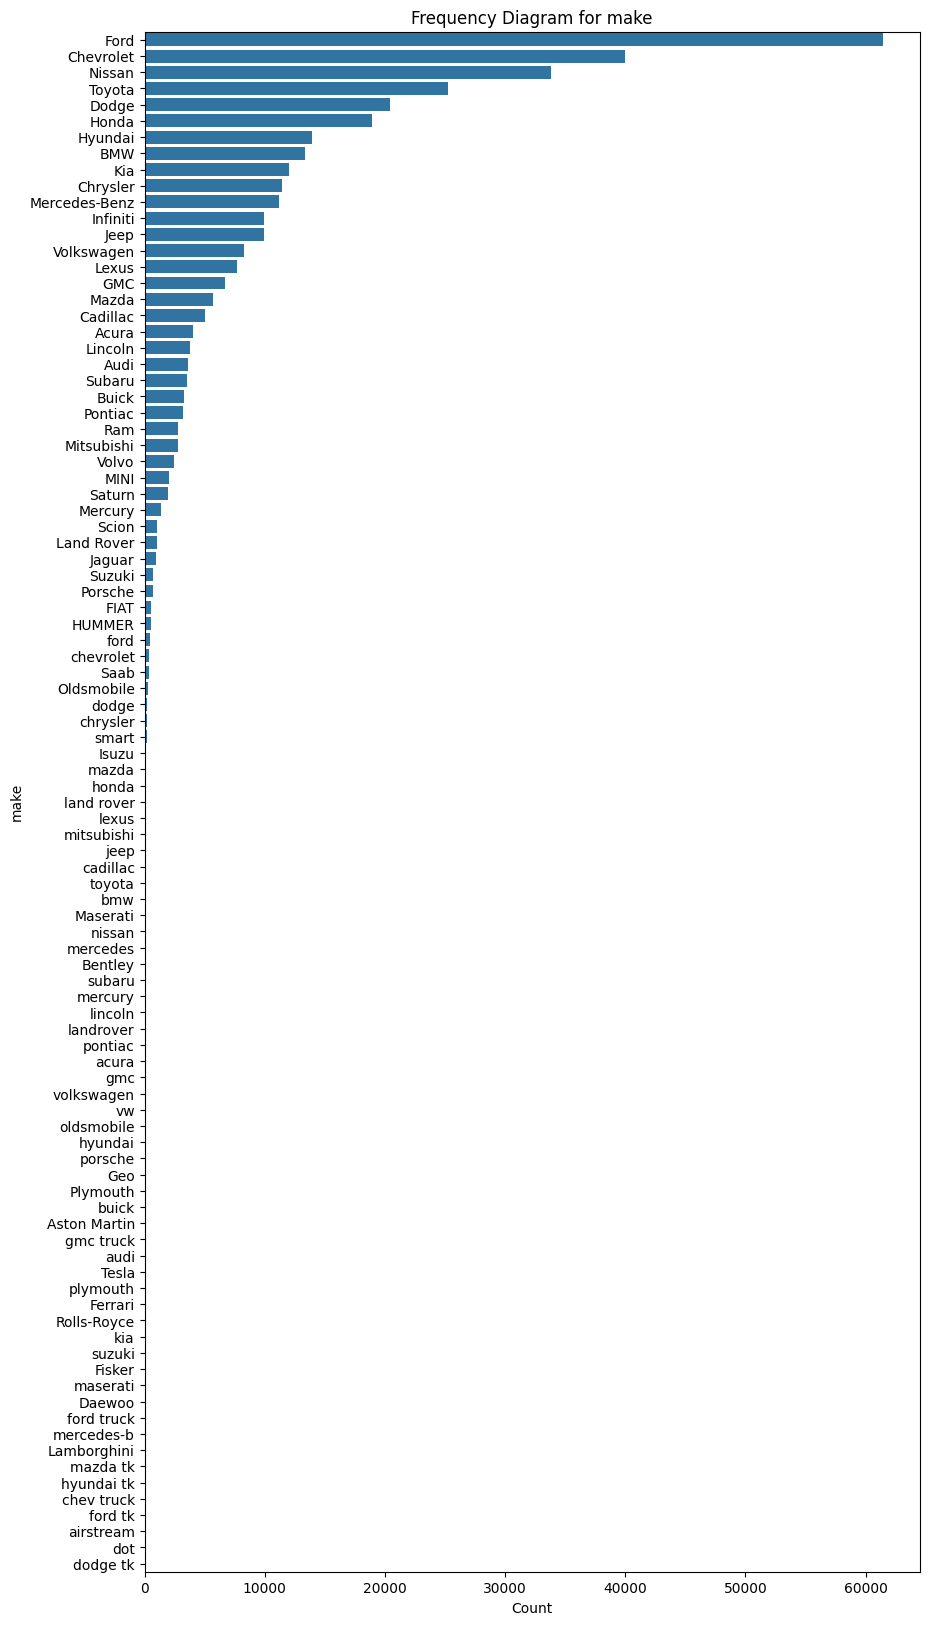

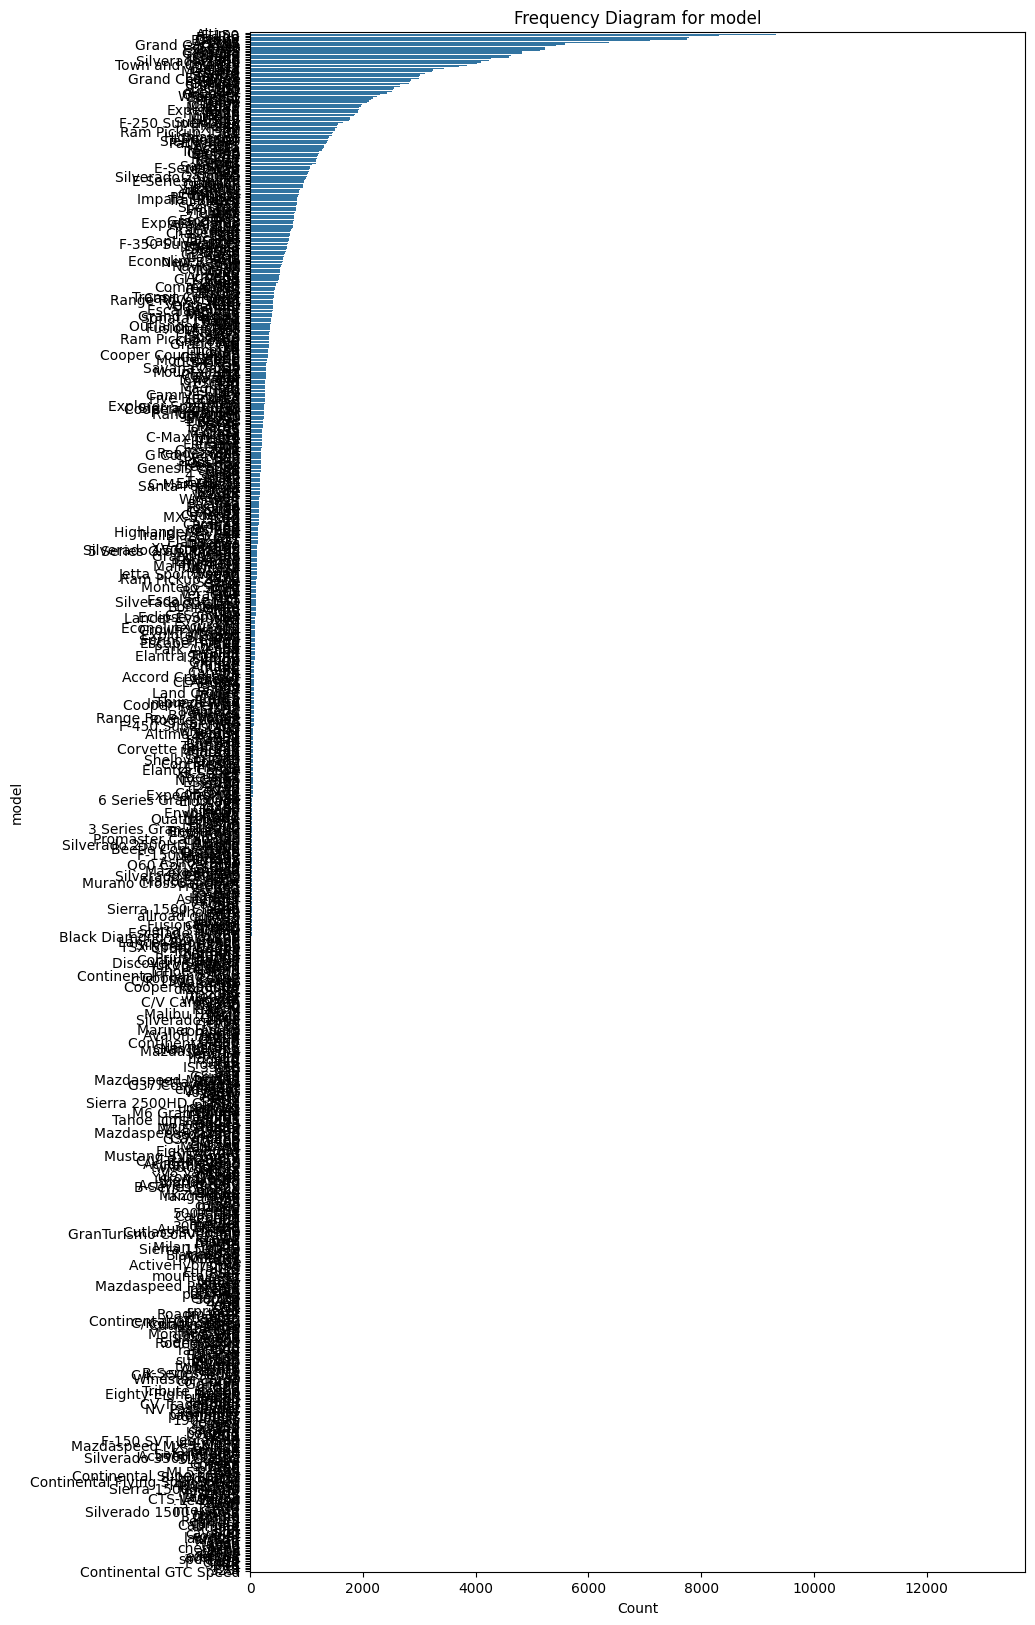

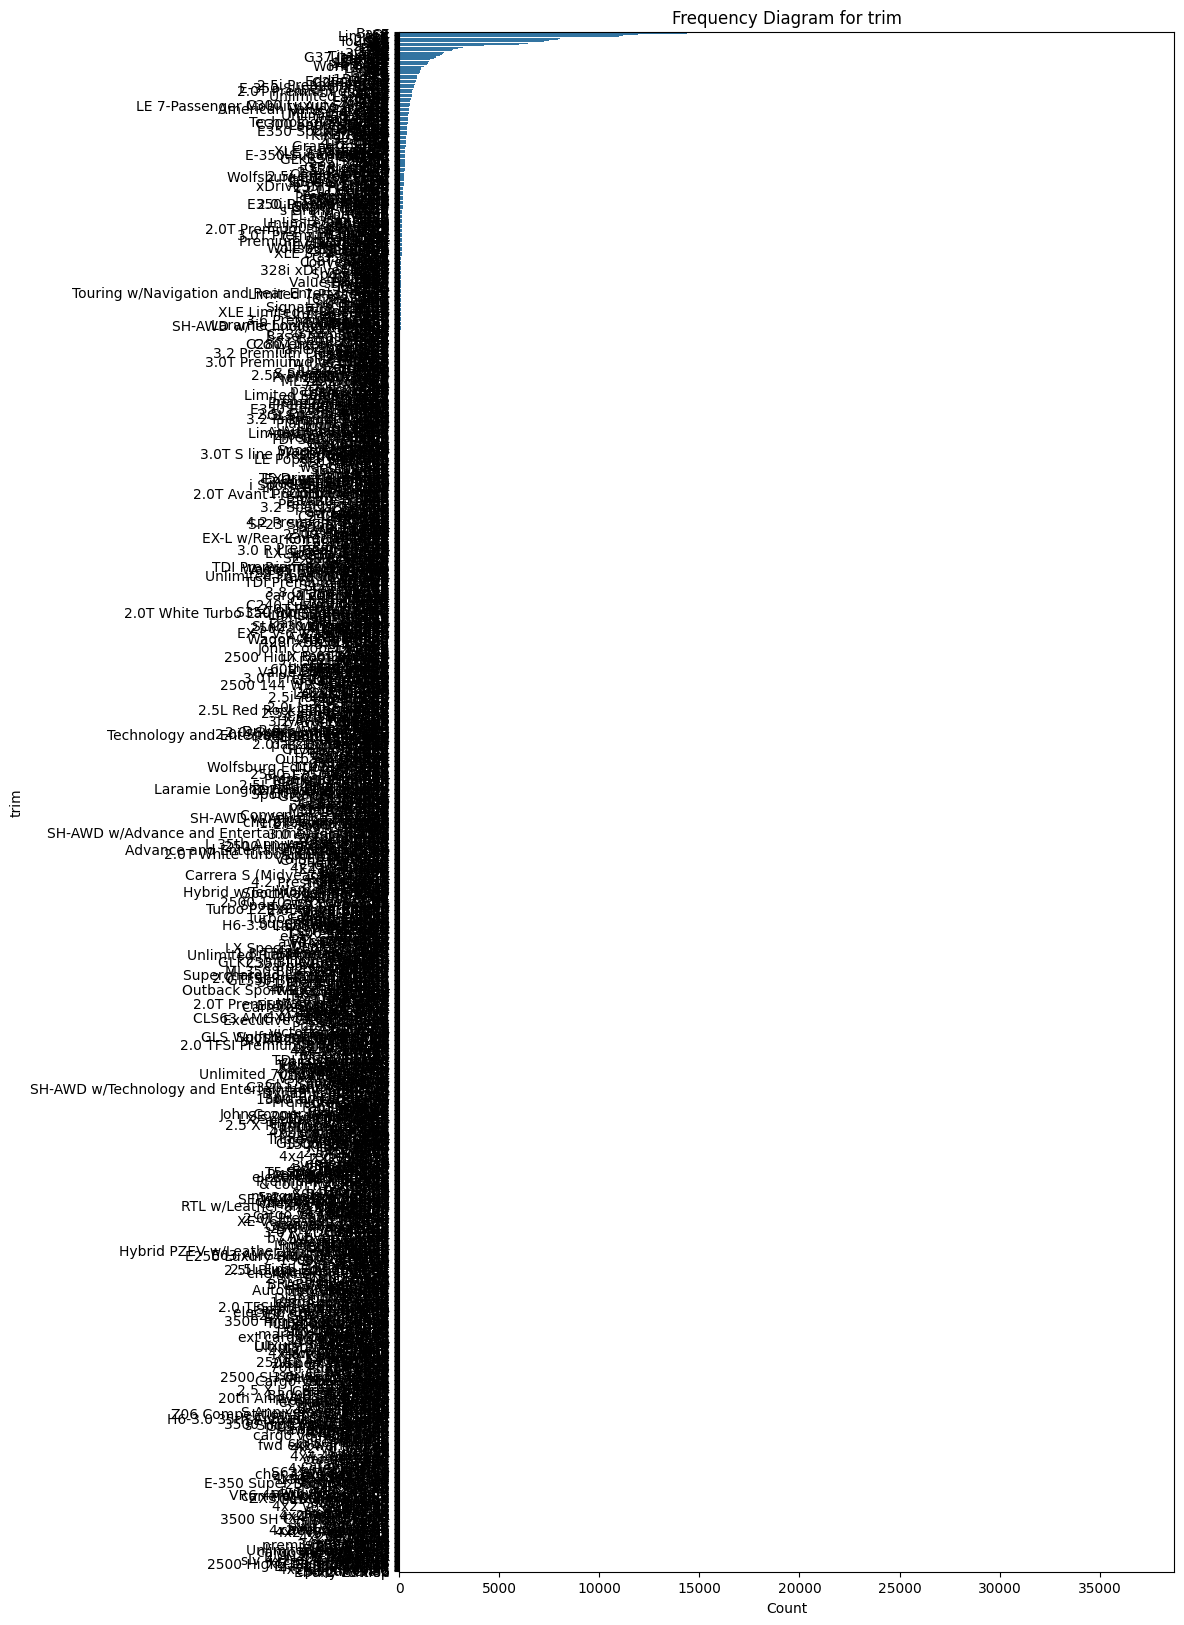

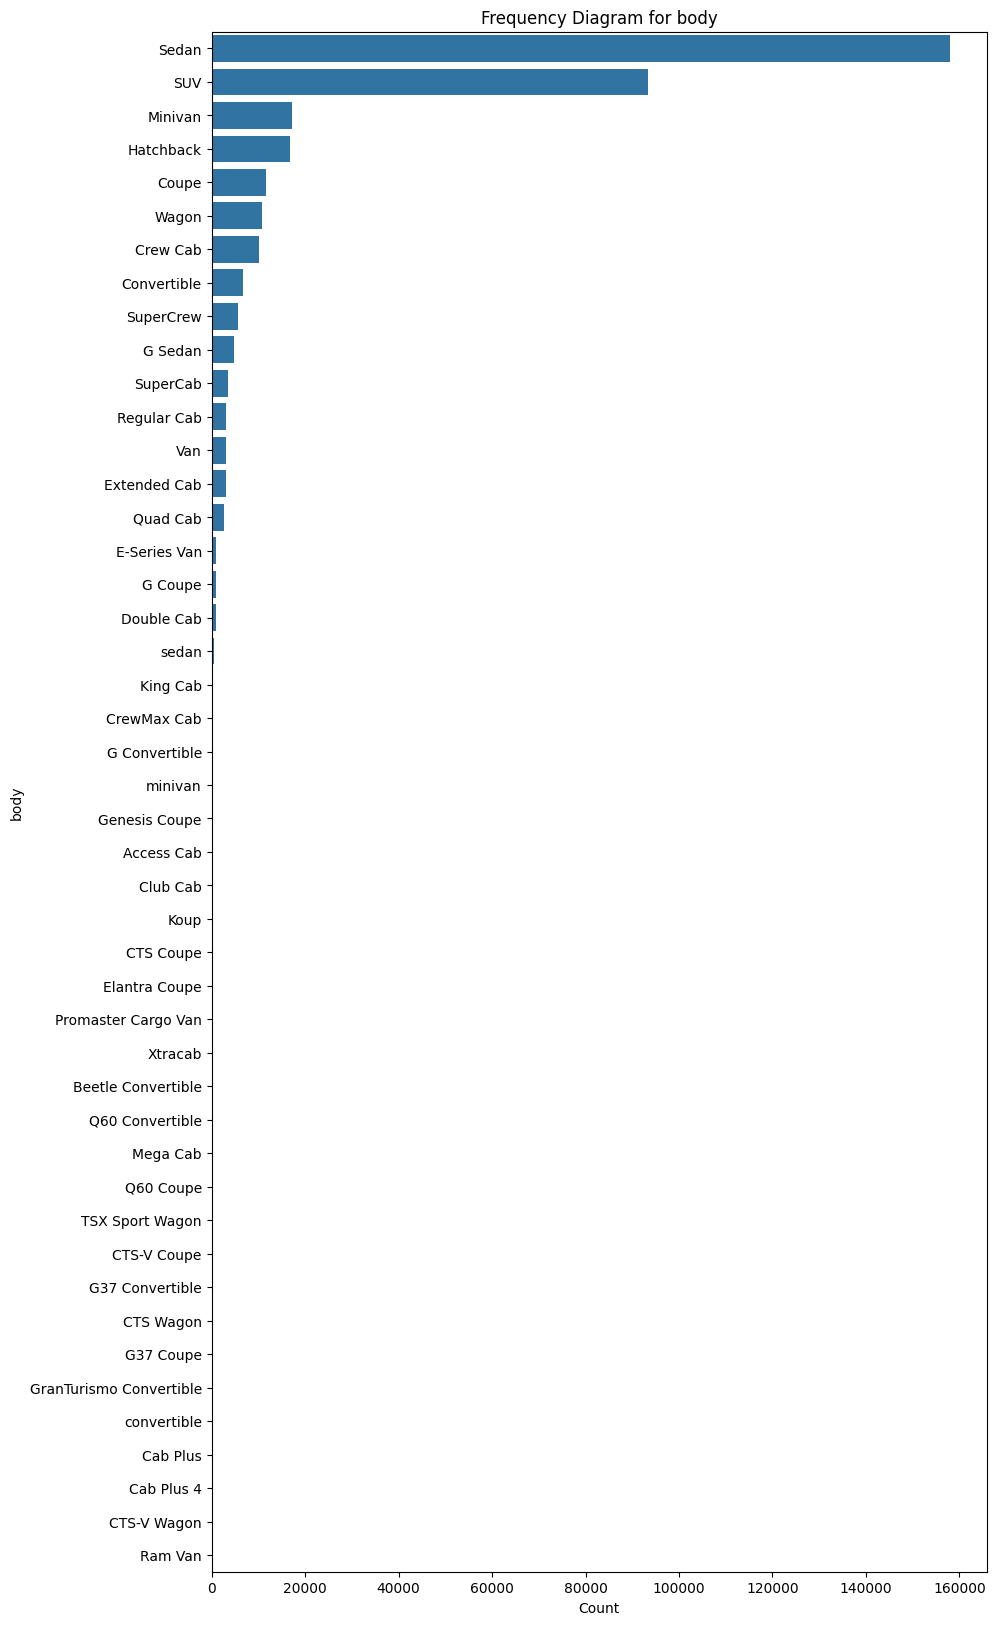

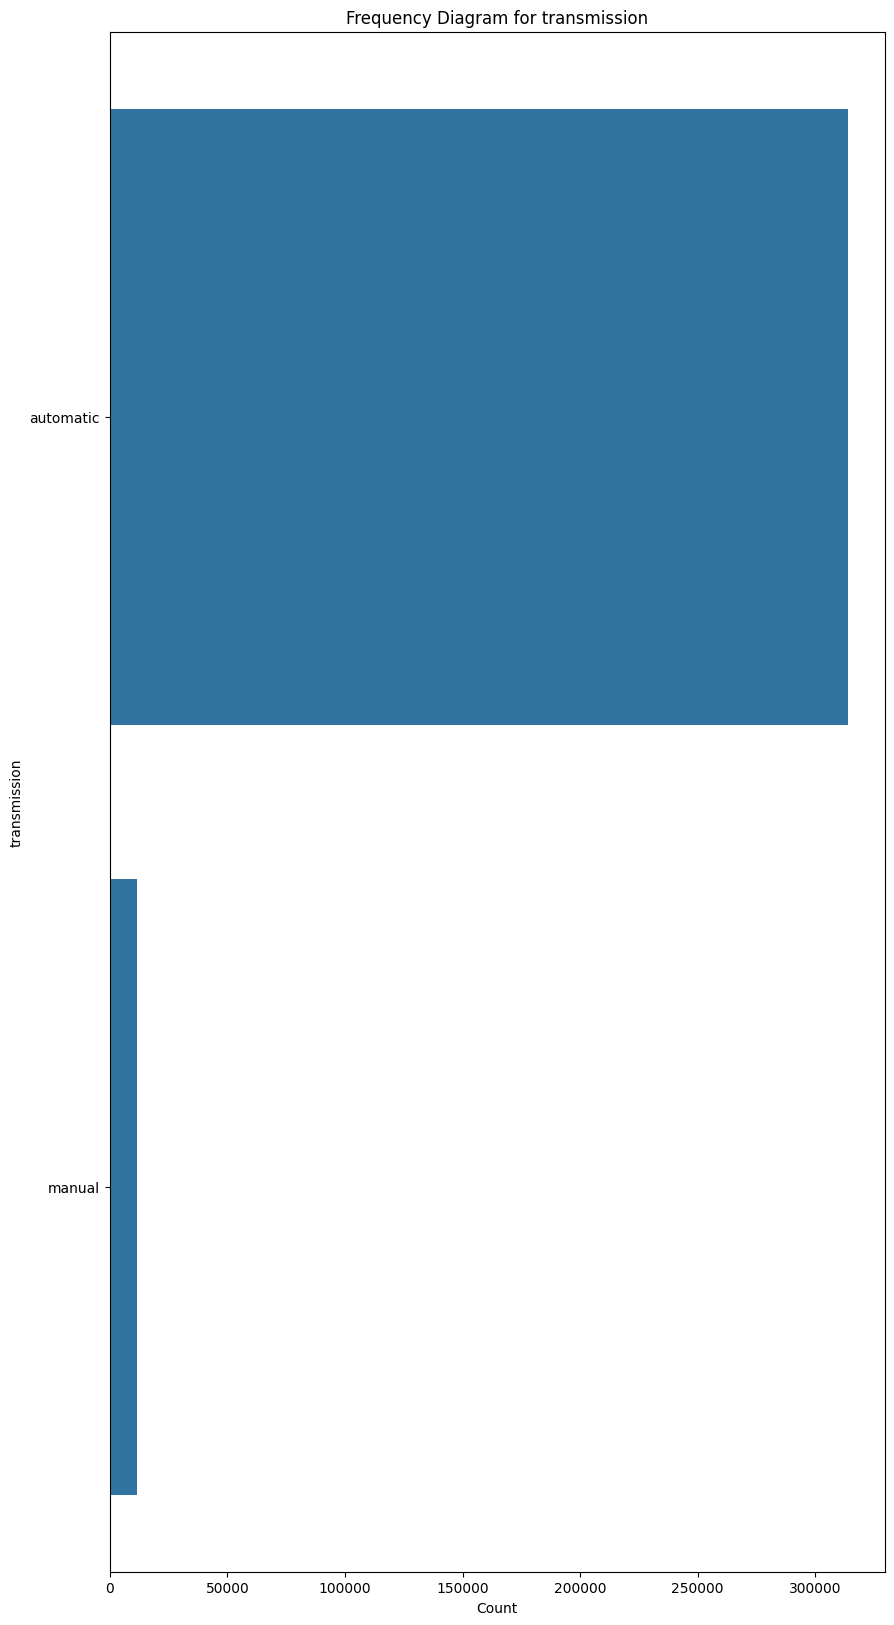

KeyboardInterrupt: 

Error in callback <function _draw_all_if_interactive at 0x7920596b0ee0> (for post_execute):


KeyboardInterrupt: 

Error in callback <function flush_figures at 0x7920596b0160> (for post_execute):


KeyboardInterrupt: 

In [14]:
# Loop through each categorical column
for col in categorical_columns:
    plt.figure(figsize=(10, 20))
    sns.countplot(y=col, data=df, order=df[col].value_counts().index)
    plt.title(f'Frequency Diagram for {col}')
    plt.xlabel('Count')
    plt.ylabel(col)
    plt.show()

In [15]:
# Get number of unique values for each categorical column
unique_counts = {col: df[col].nunique() for col in categorical_columns}
# Convert the dictionary to a DataFrame for better readability (optional)
unique_counts_df = pd.DataFrame.from_dict(unique_counts, orient='index', columns=['Unique Values'])

# Display the results
print(unique_counts)
print(unique_counts_df)

{'make': 95, 'model': 943, 'trim': 1871, 'body': 46, 'transmission': 2, 'vin': 360107, 'state': 37, 'color': 20, 'interior': 17, 'seller': 11531, 'saledate': 2414}
              Unique Values
make                     95
model                   943
trim                   1871
body                     46
transmission              2
vin                  360107
state                    37
color                    20
interior                 17
seller                11531
saledate               2414


In [16]:
#Missing value statistic
cols = []
cc = []
rr = []
for i in df.columns:
    c = len(df[i]) - df[i].count()
    if c == 0:
        continue
    r = '%.5f%%' % (c * 100/len(df[i]))
    cc.append(c)
    rr.append(r)
    cols.append(i)
null_df = pd.DataFrame({'feature': cols, 'Number of MissingValue': cc, 'Ration of MissingValue': rr})
null_df

,feature,Number of MissingValue,Ration of MissingValue
0,make,6227,1.70361%
1,model,6291,1.72112%
2,trim,6556,1.79362%
3,body,9100,2.48962%
4,transmission,40017,10.94802%
5,condition,11793,3.22638%
6,odometer,85,0.02325%
7,color,524,0.14336%
8,interior,524,0.14336%
9,mmr,2,0.00055%


In [17]:
# Get unique values of a column
unique_values = df['transmission'].unique()

print(unique_values)

['automatic' nan 'manual']


In [18]:
df['transmission'].mode()

,transmission
0,automatic


In [19]:
# Fill null values with the mode (most frequent value)
df['transmission'].fillna(df['transmission'].mode()[0], inplace=True)

In [20]:
df = df.dropna(subset=['vin', 'state','sellingprice','saledate','make', 'model', 'trim','body','condition','odometer','color','interior','mmr'])

In [23]:
# Select only numeric columns
numeric_df = df.select_dtypes(include=['float64', 'int64'])

# Compute the correlation matrix
correlation_matrix = numeric_df.corr()


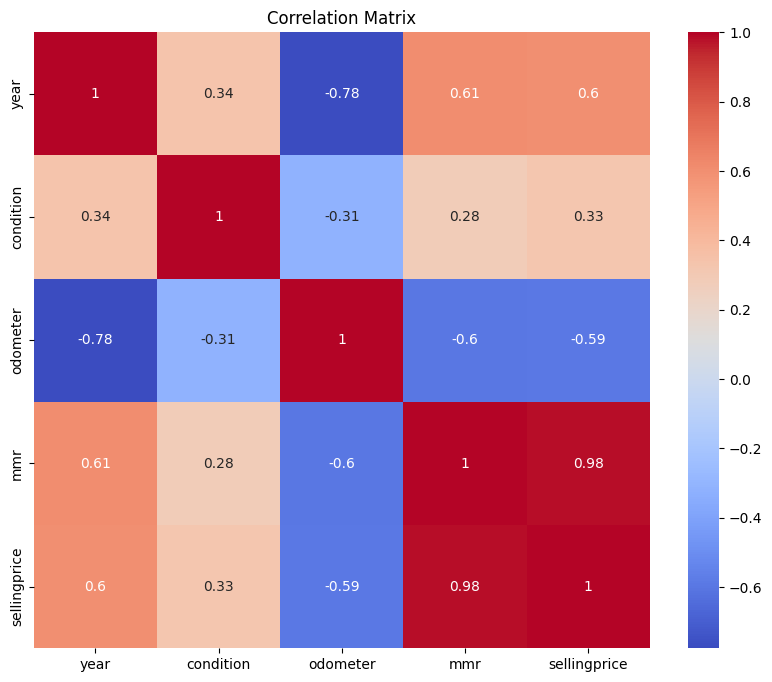

In [24]:
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', square=True)
plt.title('Correlation Matrix')
plt.show()

In [25]:
3.
#list and drop columns that are less related
cols_to_drop = ['transmission','sellingprice','saledate','vin']
df.drop(cols_to_drop, axis=1, inplace=True)

<ipython-input-25-232c42b25f6f>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop(cols_to_drop, axis=1, inplace=True)


In [26]:
df.head()

,year,make,model,trim,body,state,condition,odometer,color,interior,seller,mmr
0,2015,Kia,Sorento,LX,SUV,ca,5.0,16639.0,white,black,kia motors america inc,20500.0
1,2015,Kia,Sorento,LX,SUV,ca,5.0,9393.0,white,beige,kia motors america inc,20800.0
2,2014,BMW,3 Series,328i SULEV,Sedan,ca,45.0,1331.0,gray,black,financial services remarketing (lease),31900.0
3,2015,Volvo,S60,T5,Sedan,ca,41.0,14282.0,white,black,volvo na rep/world omni,27500.0
4,2014,BMW,6 Series Gran Coupe,650i,Sedan,ca,43.0,2641.0,gray,black,financial services remarketing (lease),66000.0


In [27]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 344716 entries, 0 to 365516
Data columns (total 12 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   year       344716 non-null  int64  
 1   make       344716 non-null  object 
 2   model      344716 non-null  object 
 3   trim       344716 non-null  object 
 4   body       344716 non-null  object 
 5   state      344716 non-null  object 
 6   condition  344716 non-null  float64
 7   odometer   344716 non-null  float64
 8   color      344716 non-null  object 
 9   interior   344716 non-null  object 
 10  seller     344716 non-null  object 
 11  mmr        344716 non-null  float64
dtypes: float64(3), int64(1), object(8)
memory usage: 34.2+ MB


In [28]:
num_duplicates = df.duplicated().sum()
print(f'Number of duplicate rows: {num_duplicates}')

Number of duplicate rows: 0


In [29]:
df.drop_duplicates(inplace=True)

<ipython-input-29-16cdb8520be8>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop_duplicates(inplace=True)


In [30]:
df.shape

(344716, 12)

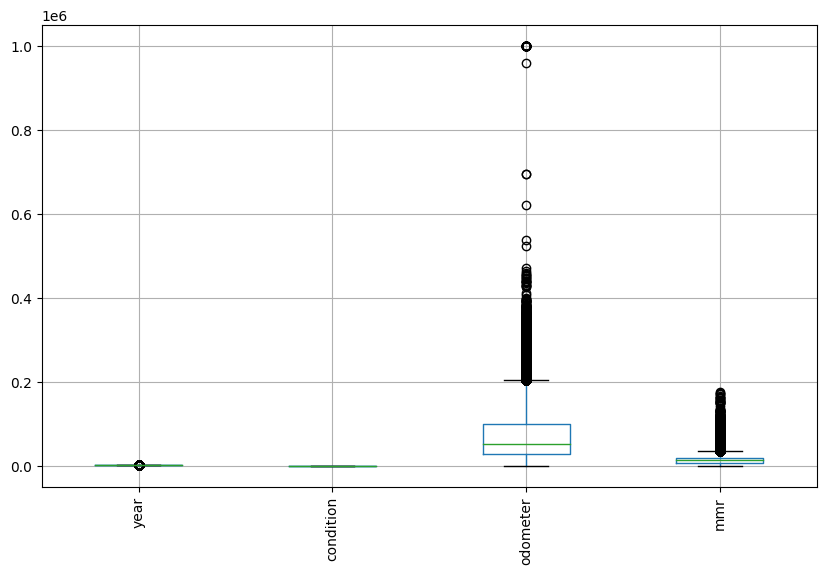

In [31]:
import pandas as pd
import matplotlib.pyplot as plt

# Filter numerical columns
numeric_cols = df.select_dtypes(include='number')

# Plot boxplot
numeric_cols.boxplot(figsize=(10, 6))  # Adjust figsize as needed
plt.xticks(rotation=90)  # Rotate the x-axis labels if necessary
plt.show()

In [32]:
import pandas as pd
import matplotlib.pyplot as plt

def remove_outliers(df, k=1.5):
    for col in df.select_dtypes(include=['float64', 'int64']):  # Apply to numerical columns
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - k * IQR
        upper_bound = Q3 + k * IQR
        # Remove outliers by keeping only values within the bounds
        df = df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]

    df = df.reset_index(drop=True)  # Reset index after removing rows
    return df

# Remove outliers
df = remove_outliers(df)

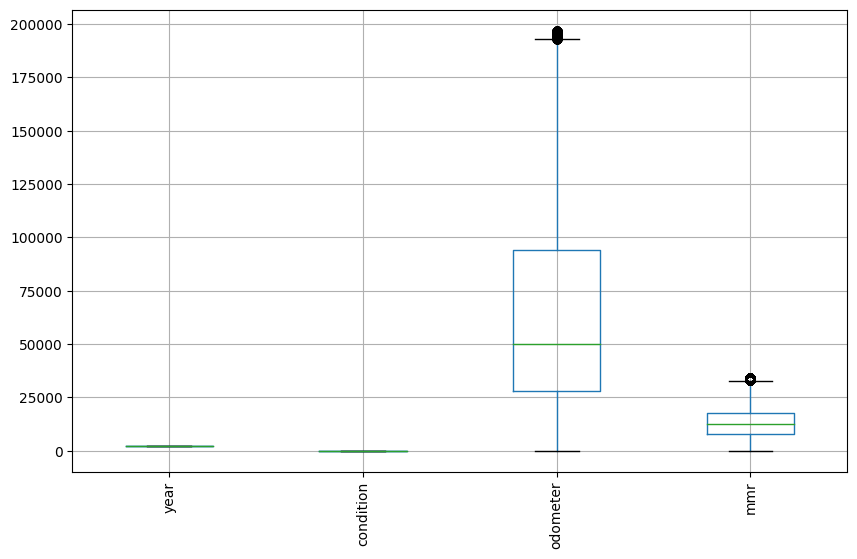

In [33]:
# Generate boxplot for the cleaned data
df.boxplot(figsize=(10, 6))
plt.xticks(rotation=90)  # Rotate column names for readability
plt.show()

In [34]:
df.shape

(320629, 12)

In [35]:
#Split to training and testing

from sklearn.model_selection import train_test_split

x = df.drop(columns = 'mmr')
y = df['mmr']

X_train, X_test, Y_train, Y_test = train_test_split(x, y, test_size=0.2,random_state=8)

Model Training : Random Forest Regressor

In [38]:
regressor = RandomForestRegressor(n_estimators = 100 )

In [45]:
categorical_columns = ['make','model','trim','body','state','color','interior','seller']

In [46]:
# Convert Categorical values in to numerical values
df[categorical_columns] = df[categorical_columns].apply(lambda x: x.astype('category').cat.codes)

In [47]:
# Training the model
regressor.fit(X_train, Y_train)

ValueError: could not convert string to float: 'Toyota'

Model Evaluation

In [ ]:
# Prediction on Test data
test_data_prediction = regressor.predict(X_test)

In [ ]:
print(test_data_prediction)

In [ ]:
# R squared error
error_score = r2_score(Y_test, test_data_prediction)
print("R squared error : ", error_score)

In [ ]:
# Calculate Mean Absolute Error
mae = mean_absolute_error(Y_test, test_data_prediction)
print(f'Mean Absolute Error for training data: {mae}')

Compare the Actual Values and Predicted Values in a plot

In [ ]:
Y_test = list(Y_test)

In [ ]:
plt.plot(Y_test, color = 'blue', label = 'Actual Value')
plt.plot(test_data_prediction, color = 'green', label = 'Predicted Value')
plt.title("Actual Price vs Predicted Price")
plt.xlabel('Number of Values')
plt.ylabel('Car Price')
plt.legend()
plt.show()